# This colab notebook provides an interactive way to get acquainted with the SPINS framework without having to install all the dependencies on your local machine. This notebook is structured to emphasize exposure to the SPINS components over efficient coding - for a better example of code for actually running inverse-design for your own devices, look at the example in `spins-b/examples/goos/bend90/bend90.py`.

In [1]:
'''
Mount your google drive folder to this notebook and set python paths so you can
access the spins-b code.
'''
# Enter the foldername in your Drive where in google drive you have saved 
# spins-b directory
# If the spins-b directory is saved in 'My Drive' of the google drive, 
# then you can leave it as ''. 
folder_name = ''

# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import os
import sys
full_path = os.path.join('/content/drive/My Drive',folder_name)
full_path_spins = os.path.join(full_path,'spins-b')
sys.path.append(full_path_spins)



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
'''
Install the spins-b library and dependencies.
'''
os.chdir(full_path)
!pip install ./spins-b



In [0]:
'''
Import necessary python libraries and SPINS-B libraries.
'''

import datetime
import logging
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np

from spins import goos
from spins.goos import compat
from spins.goos_sim import maxwell
from spins.invdes.problem_graph import optplan, log_tools

In [0]:
'''
Set up Optimization Plan object.
'''
## Create folder where all spins-b results will be saved. ##

# Currently, the folder will be named "bend90_{current_timestamp}" and will
# be located in your Drive folder containing spins-b. To change this, change
# the following line and set `out_folder_name` somewhere else.
out_folder_name = "bend90_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
out_folder = os.path.join(os.getcwd(),out_folder_name)
if (not os.path.exists(out_folder)):
  os.makedirs(out_folder)

## Setup logging and Optimization Plan. ##
plan = goos.OptimizationPlan(save_path = out_folder)

In [0]:
'''
Define the constant background structures that will not be changed
during the design. In this case, these are the input and output waveguides.
'''
with plan:
  # Define input waveguide.
  wg_in = goos.Cuboid(pos=goos.Constant([-2000, 0, 0]),
                            extents=goos.Constant([3000, 400, 220]),
                            material=goos.material.Material(index=3.45))
  # Define output waveguide.
  wg_out = goos.Cuboid(pos=goos.Constant([0, 2000, 0]),
                             extents=goos.Constant([400, 3000, 220]),
                             material=goos.material.Material(index=3.45))
  
  # Group these background structures together.
  eps_background_structures = goos.GroupShape([wg_in, wg_out])

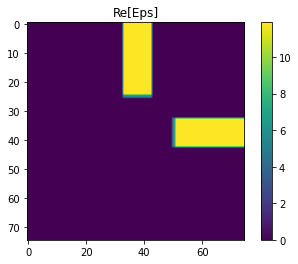

In [7]:
'''
Visualize the constant background structures we just defined.
'''
with plan:
  eps_rendered = maxwell.RenderShape(
            eps_background_structures,
            region=goos.Box3d(center=[0, 0, 0], extents=[3000, 3000, 0]),
            mesh=maxwell.UniformMesh(dx=40),
            wavelength=1550,
        )
  
  goos.util.visualize_eps(eps_rendered.get().array[2])

In [0]:
'''
Define and initialize the design region.
'''
with plan:
  # Use random initialization, where each pixel is randomly assigned
  # a value in the range [0.3,0.7].
  def initializer(size):
            # Set the seed immediately before calling `random` to ensure
            # reproducibility.
            np.random.seed(247)
            return np.random.random(size) * 0.2 + 0.5
  
  # Define the design region as a pixelated continuous shape, which is composed
  # of voxels whose permittivities can take on any value between `material` and
  # `material2`.
  var, design = goos.pixelated_cont_shape(
                initializer=initializer,
                pos=goos.Constant([0, 0, 0]),
                extents=[2000, 2000, 220],
                material=goos.material.Material(index=1),
                material2=goos.material.Material(index=3.45),
                pixel_size=[40, 40, 220],
                var_name="var_cont")
  
  eps = goos.GroupShape([eps_background_structures, design])

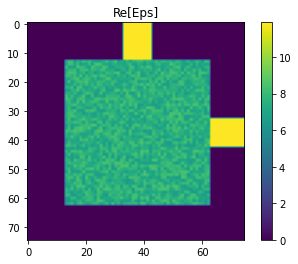

In [9]:
"""
Visualize the design region as a sanity check.
"""
with plan:
  eps_rendered = maxwell.RenderShape(
            eps,
            region=goos.Box3d(center=[0, 0, 0], extents=[3000, 3000, 0]),
            mesh=maxwell.UniformMesh(dx=40),
            wavelength=1550,
        )
  goos.util.visualize_eps(eps_rendered.get().array[2])

In [0]:
'''
Setup EM solver - in this case, we use the FDFD solver that comes with 
spins-b, maxwell.
'''
with plan:
  # Define wavelength and solver.
  my_wavelength = 1550
  my_solver = "local_direct"

  # Define simulation space.
  my_simulation_space = maxwell.SimulationSpace(
            mesh=maxwell.UniformMesh(dx=40),
            sim_region=goos.Box3d(
                center=[0, 0, 0],
                extents=[4000, 4000, 40],
            ),
            pml_thickness=[400, 400, 400, 400, 0, 0])
  
  # Define a waveguide mode source.
  my_sources = [maxwell.WaveguideModeSource(center=[-1400, 0, 0],
                                        extents=[0, 2500, 1000],
                                        normal=[1, 0, 0],
                                        mode_num=0,
                                        power=1)]
  
  
  # Define simulation outputs.
  my_outputs=[ maxwell.Epsilon(name="eps"),
               maxwell.ElectricField(name="field"),
               maxwell.WaveguideModeOverlap(name="overlap",
                                         center=[0, 1400, 0],
                                         extents=[2500, 0, 1000],
                                         normal=[0, 1, 0],
                                         mode_num=0,
                                         power=1)]

  # Setup the simulation object.
  sim = maxwell.fdfd_simulation(
        name="sim_cont",
        wavelength= my_wavelength,
        background=goos.material.Material(index=1.0),
        eps=eps,
        simulation_space = my_simulation_space,
        solver = my_solver,
        sources = my_sources,
        outputs= my_outputs
    )

/usr/local/lib/python3.6/dist-packages/scipy/sparse/data.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  self._deduped_data().astype(dtype, casting=casting, copy=copy),


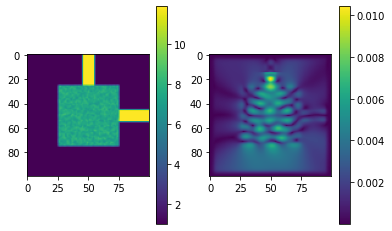

Initial overlap is 0.039619461684399296.


In [11]:
'''
Visualize simulation of initial structure, as a sanity check.
'''
with plan:
  initial_structure = np.squeeze(sim['eps'].get().array)
  initial_field = np.squeeze(sim['field'].get().array)
  initial_overlap = np.squeeze(sim['overlap'].get().array)

  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(
    np.abs(
      initial_structure[2]))
  plt.colorbar()

  plt.subplot(1,2,2)
  plt.imshow(
    np.abs(
      initial_field[2]))
  plt.colorbar()
  plt.show()

  print("Initial overlap is {}.".format(np.abs(initial_overlap)))



In [0]:
"""
Define objective function to maximize the transmission of the fundamental
waveguide mode.
"""
obj = goos.rename(goos.abs(sim["overlap"]), name="obj_cont")

In [0]:
"""
Setup the optimization strategy.
"""
with plan:
  goos.opt.scipy_maximize(
                obj,
                "L-BFGS-B",
                monitor_list=[sim["eps"], sim["field"], sim["overlap"], obj],
                max_iters=15,
                name="opt_cont")

In [0]:
"""
Save the plan.
"""
with plan:
  plan.save()

In [15]:
"""
Run the plan.
"""
# Setup logging.
LOG_FORMAT = "[%(asctime)-15s][%(levelname)s][%(module)s][%(funcName)s] %(message)s"
logging.basicConfig(stream=sys.stdout,format=LOG_FORMAT)
logging.getLogger("").setLevel(logging.INFO)
logger = logging.getLogger("")

# Run the plan.
with plan:
  plan.run()

[2020-06-04 21:01:41,655][INFO][optplan][run] Running action 0 (opt_cont).
[2020-06-04 21:01:50,339][INFO][optplan][write_event] Evaluating monitors for action 0 (opt_cont) with event info {'state': 'optimizing', 'iteration': 1} [1].
[2020-06-04 21:01:50,407][INFO][optplan][write_event] Monitor sim_cont.overlap: (-0.13199193978490026+0.08190581998462378j) (mag=0.15533974222823446, phase=2.5862094669325644)
[2020-06-04 21:01:50,408][INFO][optplan][write_event] Monitor obj_cont: 0.15533974222823446
[2020-06-04 21:01:50,424][INFO][optplan][write_event] Data saved to /content/drive/My Drive/bend90_20200604-204840/step1.pkl
[2020-06-04 21:01:54,559][INFO][optplan][write_event] Evaluating monitors for action 0 (opt_cont) with event info {'state': 'optimizing', 'iteration': 2} [2].
[2020-06-04 21:01:54,615][INFO][optplan][write_event] Monitor sim_cont.overlap: (-0.2428255293142784+0.5468193239237373j) (mag=0.5983106306118692, phase=1.98870712618925)
[2020-06-04 21:01:54,616][INFO][optplan][wr

In [0]:
"""
Set the folder for visualizing optimization results.
"""
# Currently, this will visualize results in the output folder defined 
# at the beginning of this notebook in the cell where we define the 
# OptimizationPlan object - but, you can change this variable
# to visualize results from other folders in your google drive.
folder_plt = out_folder

In [17]:
"""
Open a pkl file and look at what's inside, as a sanity check.
"""
with open(os.path.join(folder_plt, "step1.pkl"), "rb") as fp:
  data = pickle.load(fp)

print("Pkl dictionary: ", data.keys())
print("'monitor_data' dictionary: ", data['monitor_data'].keys())
print("'objective value': ", data['monitor_data']['obj_cont'])

Pkl dictionary:  dict_keys(['version', 'action_ptr', 'action', 'time', 'variable_data', 'transformation', 'parametrization', 'event', 'monitor_data', 'log_counter'])
'monitor_data' dictionary:  dict_keys(['sim_cont.eps', 'sim_cont.field', 'sim_cont.overlap', 'obj_cont'])
'objective value':  0.15533974222823446


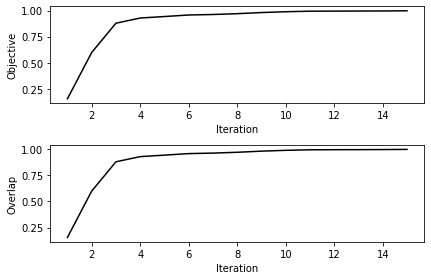

In [18]:
"""
Visualize the objective function and overlap monitors as a function of iteration.
"""

# Load the logged monitor data.
df = log_tools.create_log_data_frame(log_tools.load_all_logs(folder_plt))
monitor_obj = log_tools.get_joined_scalar_monitors(df,"obj_cont",
                                                   event_name = "optimizing", scalar_operation = None)
monitor_overlap = log_tools.get_joined_scalar_monitors(df,"sim_cont.overlap",
                                                       event_name = "optimizing",scalar_operation = "magnitude")

# Plot the logged monitor data.
plt.figure()

plt.subplot(2, 1, 1)
plt.plot(monitor_obj.iterations,monitor_obj.data,'k-')
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.tight_layout()

plt.subplot(2, 1, 2)
plt.plot(monitor_overlap.iterations,monitor_overlap.data,'k-')
plt.xlabel("Iteration")
plt.ylabel("Overlap")
plt.tight_layout()

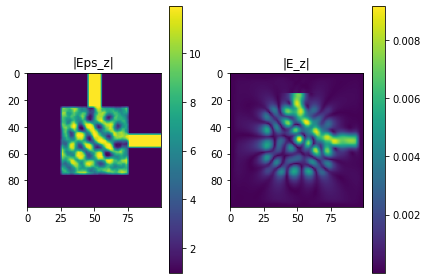

In [19]:
"""
Visualize the final structure and fields.
"""
step = goos.util.get_latest_log_step(folder_plt)

with open(os.path.join(folder_plt, "step{}.pkl".format(step)), "rb") as fp:
  data = pickle.load(fp)

plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(
    np.abs(data["monitor_data"]["sim_cont.eps"][2].squeeze()))
plt.colorbar()
plt.title("|Eps_z|")
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.imshow(
    np.abs(
      data["monitor_data"]["sim_cont.field"][2].squeeze()))
plt.colorbar()
plt.title("|E_z|")
plt.tight_layout()

plt.savefig(os.path.join(folder_plt,"fields_step"+str(step)+".png"))
plt.show()

The next two cells are here to play around with how the CubicParam parametrization initial conditions look with different `control_point_spacing` and different `sigmoid_factor` thresholding strengths.

In [0]:
"""
Switch to using CubicParam.
"""
# We setup a temporary optimization plan object here so everything constructed
# here is not added to the optimization plan we have been working with in this
# example. So, you can modify the parametrizations here without affecting
# anything defined previously in this notebook.
temp_plan = goos.OptimizationPlan()

with temp_plan:
  # Use random initialization, where each pixel is randomly assigned
  # a value in the range [0.3,0.7].
  def initializer(size):
            # Set the seed immediately before calling `random` to ensure
            # reproducibility.
            np.random.seed(247)
            return np.random.random(size) * 0.2 + 0.5
  
  # Define the design region using bicubic interpolation parametrization, 
  # where the voxel values for the pixels of size `pixel_spacing` are set
  # by doing bicubic interpolation of the permittivity values on a coarse grid
  # where each point is separated by `control_point_spacing`.
  # `control_point_spacing` roughly controls the feature sizes produced
  # in the final device (so a larger `control_point_spacing` should be used
  # to produce a device with larger features).
  var, design = goos.cubic_param_shape(
                initializer=initializer,
                pos=goos.Constant([0, 0, 0]),
                extents=[2000, 2000, 220],
                material=goos.material.Material(index=1),
                material2=goos.material.Material(index=3.45),
                pixel_spacing=40,
                control_point_spacing=200,
                var_name="var_cont_cubic")
  
  # To push the designed device to be more discrete (i.e. consist only of the
  # background and foreground materials), setup thresholding by multiplying 
  # the cubic parametrization by a sigmoid function to push permittivity values
  # toward either the background or foreground index. The `sigmoid_factor`
  # controls how steep the sigmoid function is and thus how discrete the device
  # will be. The `bend90.py` example in this directory shows an example of a
  # more complex optimization strategy where we run multiple optimization
  # stages and gradually increase the strength of the sigmoid thresholding.
  sigmoid_factor = goos.Variable(8, parameter=True, name="discr_factor")
  design = goos.cast(goos.Sigmoid(sigmoid_factor * (2 * design - 1)),
                           goos.Shape)
  eps = goos.GroupShape([eps_background_structures, design])

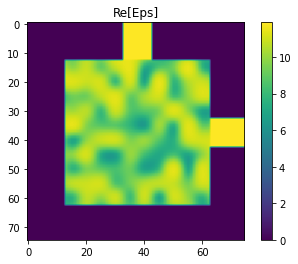

In [27]:
"""
Visualize the structure we have initialized in the previous cell.
"""
with temp_plan:
  eps_rendered = maxwell.RenderShape(
            eps,
            region=goos.Box3d(center=[0, 0, 0], extents=[3000, 3000, 0]),
            mesh=maxwell.UniformMesh(dx=40),
            wavelength=1550,
        )
  goos.util.visualize_eps(eps_rendered.get().array[2])